In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from matplotlib import pyplot as plt

from numba import jit

from scipy.special import comb
import scipy.optimize as optimize

%matplotlib inline

## 1. Callable Bond Function

In [7]:
#return interst rate of each node
@jit
def generateBTR(r0,drift,sigma,n,year): 
    n_level = n * year
    BT = np.zeros((n_level, n_level))
    BT[0][0] = r0
    deltaT=1/n
    for i in range(1, n_level):
        BT[:, i] = BT[:, i - 1] * np.exp(drift*deltaT+sigma*np.sqrt(deltaT))
        BT[i][i] = BT[i - 1][i - 1] * np.exp(drift*deltaT-sigma*np.sqrt(deltaT))
    return BT

#return discount rate between each deltaT
@jit
def generateBT(r0,drift,sigma,n,year): 
    BTR = generateBTR(r0,drift,sigma,n,year)
    deltaT=1/n
    return np.exp(-BTR*deltaT)

@jit
def discountedValue(BT,n):
    result = BT[:n, n - 1]
    for i in np.arange(n-1,0,-1):
        result = 0.5 * (result[:-1] + result[1:]) * BT[:i, i - 1]
    return result[0]

'''
r0=current continous conpouding short rate
drift,sigma=parameters in model
n=numer of steps in year
year=matirity
cFrq=how many times of coupon payment per year
c=coupon rate
principle=face value
'''
@jit
def vanillaBond(r0,drift,sigma,n,year,cFrq,c,principle):
    BT=generateBT(r0,drift,sigma,n,year)
    price=principle*discountedValue(BT,year*n) 
    for t in np.array(range(1,cFrq*year+1))/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BT,int(t*n))  
    return price

@jit
def callableBond(r0,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime):
    
    BTRt=generateBTR(r0,drift,sigma,n,callTime)
    BTt=generateBT(r0,drift,sigma,n,callTime)
    
    newR=BTRt[:, n*callTime - 1].squeeze()
    len_newR = len(newR)
    
    price=0
    count=0
    for r in newR:
        p1=min(vanillaBond(r,drift,sigma,n,year-callTime,cFrq,c,principle),callPirce)
        price+=p1*discountedValue(BTt,callTime*n)*comb(len_newR-1, count)/(2**(len(newR)-1))
        count+=1
        
    for t in np.arange(1,cFrq*callTime+1)/cFrq:
        price+=(c/cFrq)*principle*discountedValue(BTt,int(t*n))  
    return price

def ytm(price,c,principle,cFrq,year):
    
    freq = float(cFrq)
    periods = year*freq
    coupon = c*principle/cFrq
    dt = [(i+1)/freq for i in range(int(periods))]
    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + principle/(1+y/freq)**(freq*year) - price
    
    return optimize.newton(ytm_func, 0.03)

## 2. Simulate Price and Duration

In [8]:
libor3m = pd.read_excel('libor 3m.xlsx')
libor3m.head()

,Date,US0003M Index
0,2015-05-13,0.2739
1,2015-05-14,0.2760
2,2015-05-15,0.2765
3,2015-05-18,0.2760
4,2015-05-19,0.2810


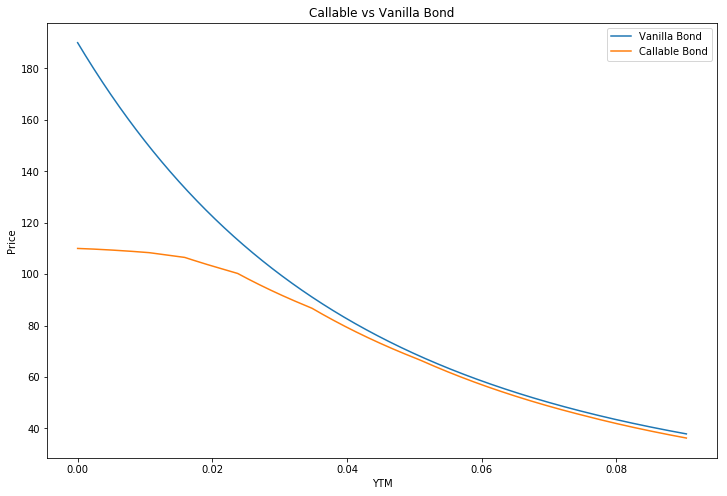

In [9]:
drift=0.01
sigma=0.4
n=2
year=30
cFrq=2
c=0.03
principle=100
callPirce=101
callTime=3
deltaR=0.01

y=[]
price=[]
priceC=[]
for r in np.arange(0,1000)*0.0001:
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    price.append(p)
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
plt.figure(figsize=(12,8))    
plt.plot(y,price,label='Vanilla Bond') 
plt.plot(y,priceC,label='Callable Bond')
plt.title('Callable vs Vanilla Bond')
plt.xlabel('YTM')
plt.ylabel('Price')
plt.legend()
plt.show()

### Simulate price and duration with BDT model

In [11]:
y=[]
priceC=[]
duration=[]
R=np.array(libor3m['US0003M Index'])/100
for r in R:
    p=vanillaBond(r,drift,sigma,n,year,cFrq,c,principle)
    y.append(ytm(p,c,principle,cFrq,year))
    priceC.append(callableBond(r,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))
    duration.append((callableBond(r+deltaR,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime)-\
                    callableBond(r-deltaR,drift,sigma,n,year,cFrq,c,principle,callPirce,callTime))/(2*deltaR))
#print(priceC)

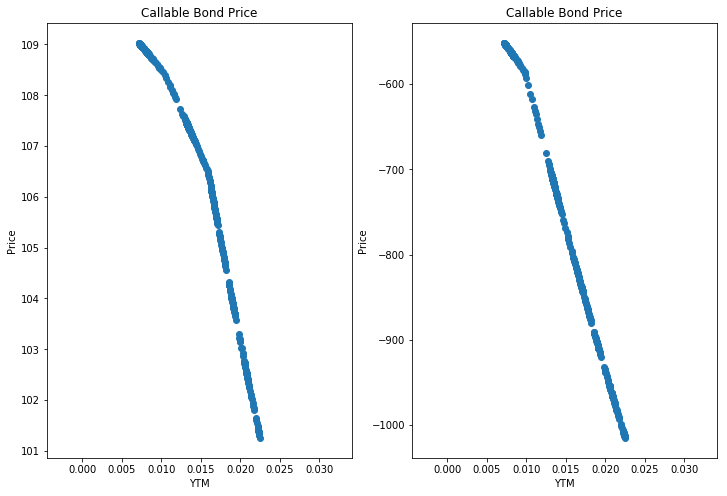

In [12]:
fig = plt.figure(figsize=(12,8))    

ax1 = fig.add_subplot(121)
ax1.scatter(y,priceC,label='Callable Bond Price')
ax1.set_title('Callable Bond Price')
ax1.set_xlabel('YTM')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(122)
ax2.scatter(y,duration,label='Callable Bond Duration over r')
ax2.set_title('Callable Bond Price')
ax2.set_xlabel('YTM')
ax2.set_ylabel('Price')

### Issue1: the real libor is not low enough to have the negative convexity. Test needs to be done to find the parameters that allows call option to take effect for real 3M Libor data

## 2.1 To find Relation Plot Duration Against 3m Libor

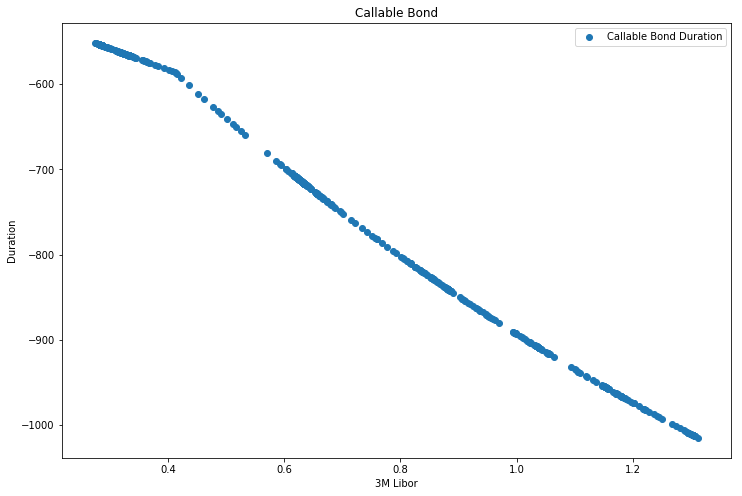

In [13]:
plt.figure(figsize=(12,8))    
plt.scatter(np.array(libor3m['US0003M Index']),duration,label='Callable Bond Duration')
plt.title('Callable Bond')
plt.xlabel('3M Libor')
plt.ylabel('Duration')
plt.legend()
plt.show()

## 2.2 To find Relation Plot Duration Against Price

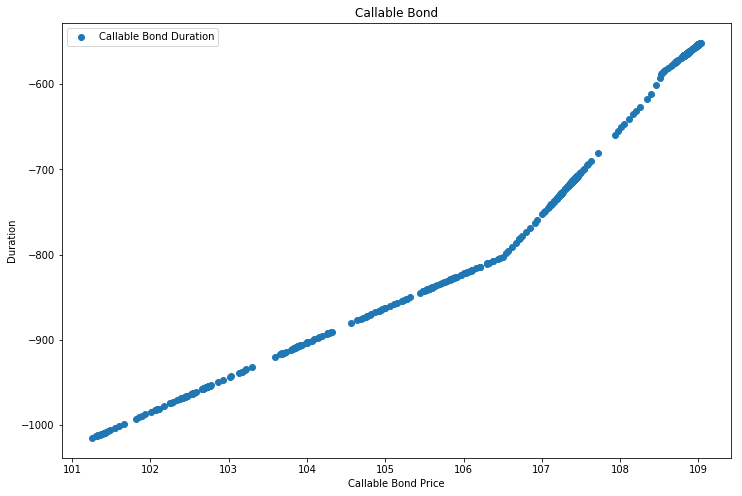

In [14]:
plt.figure(figsize=(12,8))    
plt.scatter(priceC,duration,label='Callable Bond Duration')
plt.title('Callable Bond')
plt.xlabel('Callable Bond Price')
plt.ylabel('Duration')
plt.legend()
plt.show()

## 2.3 Use Polynomial to Fince Duration = f(Price, r)

In [15]:
#http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions
def poly2Var(duration,priceC,R,deg):
    X = np.hstack((R.reshape(len(R),1), np.array(priceC).reshape(len(priceC),1)))
    vector = duration
    poly = PolynomialFeatures(degree=deg)
    X_=poly.fit_transform(X)
    clf = linear_model.LinearRegression()
    clf.fit(X_, vector)
    
    #test the fit
    predict= X.copy()
    predict_ = poly.fit_transform(predict)
    return [clf.coef_,clf.predict(predict_),clf.score(predict_, vector)]

In [16]:
coef,fit,r2=poly2Var(duration,priceC,R,2)

In [17]:
coef

array([  0.00000000e+00,   8.32341169e+06,   1.07110717e+04,
        -2.66720585e+07,  -7.48397420e+04,  -4.76308197e+01])

In [18]:
r2

0.99982930334649611